# Computational Neuroscience Project
## EOG classifier

### Loading data

In [ ]:
import os

# from google.colab import drive
# drive.mount('/content/drive')

folders = os.listdir()
if 'CNS_EOG' not in folders:
    !git clone https://github.com/JRodrigoF/CNS_EOG.git

In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
import datetime
import os, sys
import random
import gc

from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

#prefix_path = 'data/eog_office/'
prefix_path = 'CNS_EOG/data/eog_office/'

mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('.mat')])

column_names = ['seconds', 'microseconds', 'EOG_H', 'EOG_V', 'class']

data = []
for file in mat_files:
    mat = sio.loadmat(prefix_path + file)
    participant = file.split('_')[0].replace('participant', '')
    exp_run = file.split('_')[1].replace('.mat', '')

    df = (
        pd.DataFrame(mat['data'], columns=column_names)
        .assign(activity=lambda x: x['class']
                .replace({1: 'null', 2: 'read', 3: 'browse', 4: 'write',
                        5: 'video', 6: 'copy', 7: 'disspeak', 8: 'disphone'})
                .astype('category')
                )
        .assign(unix_time=lambda x: x['seconds'] + (x['microseconds'] / 1000000))
        .assign(participant=lambda x: participant)
        .assign(exp_run=lambda x: exp_run)
        .assign(sex=lambda x: x['participant']
                .replace({'1': 'male', '2': 'male', '3': 'male', '4': 'male',
                        '5': 'male', '6': 'female', '7': 'female', '8': 'male'})
                .astype('category')
                )
        .assign(time_normalized=lambda x: x['unix_time'] - x['seconds'][0])
        .assign(full_date=lambda x: pd.to_datetime(x['seconds'], unit='s')
                .astype('datetime64'))
        .assign(date=lambda x: pd.to_datetime(x['seconds'], unit='s').dt.date
                .astype('datetime64'))
        .assign(time=lambda x: pd.to_datetime(x['seconds'], unit='s').dt.time)
    )

    new_dtypes = {"class": 'category', 'participant': 'category',
                    'exp_run': 'category', 'time': 'string'}

    df = df.astype(new_dtypes)
    data.append(df)

rand_exp = int(random.sample(range(1,15),1)[0])

display("Random experiment: ", rand_exp)
display(data[rand_exp])
display(data[rand_exp].dtypes)


'Random experiment: '

2

,seconds,microseconds,EOG_H,EOG_V,class,activity,unix_time,participant,exp_run,sex,time_normalized,full_date,date,time
0,1237456558,987184,-15130,1433567,1,null,1.237457e+09,2,0,male,0.987184,2009-03-19 09:55:58,2009-03-19,09:55:58
1,1237456558,987271,-28374,1434097,1,null,1.237457e+09,2,0,male,0.987271,2009-03-19 09:55:58,2009-03-19,09:55:58
2,1237456559,103143,-23001,1437780,1,null,1.237457e+09,2,0,male,1.103143,2009-03-19 09:55:59,2009-03-19,09:55:59
3,1237456559,103233,-23251,1437142,1,null,1.237457e+09,2,0,male,1.103233,2009-03-19 09:55:59,2009-03-19,09:55:59
4,1237456559,103256,-26571,1440331,1,null,1.237457e+09,2,0,male,1.103256,2009-03-19 09:55:59,2009-03-19,09:55:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221046,1237458327,919128,-257483,1360843,4,write,1.237458e+09,2,0,male,1769.919128,2009-03-19 10:25:27,2009-03-19,10:25:27
221047,1237458327,935101,-256954,1361830,4,write,1.237458e+09,2,0,male,1769.935101,2009-03-19 10:25:27,2009-03-19,10:25:27
221048,1237458327,947105,-255775,1361911,4,write,1.237458e+09,2,0,male,1769.947105,2009-03-19 10:25:27,2009-03-19,10:25:27
221049,1237458327,963097,-255223,1361334,4,write,1.237458e+09,2,0,male,1769.963097,2009-03-19 10:25:27,2009-03-19,10:25:27


seconds                     int32
microseconds                int32
EOG_H                       int32
EOG_V                       int32
class                    category
activity                 category
unix_time                 float64
participant              category
exp_run                  category
sex                      category
time_normalized           float64
full_date          datetime64[ns]
date               datetime64[ns]
time                       string
dtype: object

### Visual overview

In [ ]:
from CNS_EOG.utils.plotnine_grid import plotnine_grid

sample_preffixes = [f.replace('_', '_run_')
                .replace('participant', 'Participant_')
                .replace('.mat', '') for f in mat_files]

sample_titles = [f.replace('_', ' ') for f in sample_preffixes]

brewer_set = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
                '#ff7f00', '#ffff33', '#a65628', '#f781bf']

brewer_paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C",
                "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928"]

raw_data_plots = sorted([f for f in os.listdir("CNS_EOG/imgs/eog_data/")
                        if f.startswith('Participant_') and f.endswith('.png')])

def two_panel_plot(data, x, y1, y2, color_by_1, color_by_2, plot_title,
                x_lab, color_palette, size=0.4, alpha=0.9, index=None, out_plot=None):

        if index != None:
                data_frame = data[index]
        else:
                data_frame = data

        p = ggplot(data_frame)
        p = p + geom_line(aes(x, y1, color=color_by_1),
                        size=size, alpha=alpha)
        p = p + scale_color_manual(color_palette)
        p = p + labs(x=x_lab, y='EOG H', title=plot_title)
        p = p + theme_classic()
        p = p + theme(legend_key=element_rect(color = "white"))
        # display(p)

        q = ggplot(data_frame)
        q = q + geom_line(aes(x, y2, color=color_by_2),
                        size=size, alpha=alpha)
        q = q + scale_color_manual(color_palette)
        q = q + labs(x=x_lab, y='EOG V', title=plot_title)
        q = q + theme_classic()
        q = q + theme(legend_key=element_rect(color = "white"))
        # display(p)

        plotnine_grid([p, q], row=None, col=1, height=4, width=6, dpi=300,
                ratio=None, pixels=10000, figsize=(12, 8), file=out_plot)

if len(raw_data_plots) != 16:
        for i in range(len(data)):
                ordered_categories = list(data[i]['activity'].unique())
                data[i] =  data[i].assign(activity=pd.Categorical(
                        data[i]['activity'], ordered_categories))

                out_plot='CNS_EOG/imgs/eog_data/{}.png'.format(sample_preffixes[i])
                plot_title="Raw Data \n{}".format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time_normalized'
                y1='EOG_H'
                y2='EOG_V'
                color_by_1='activity'
                color_by_2='activity'

                two_panel_plot(data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.4, alpha=0.9, index=i, out_plot=out_plot)

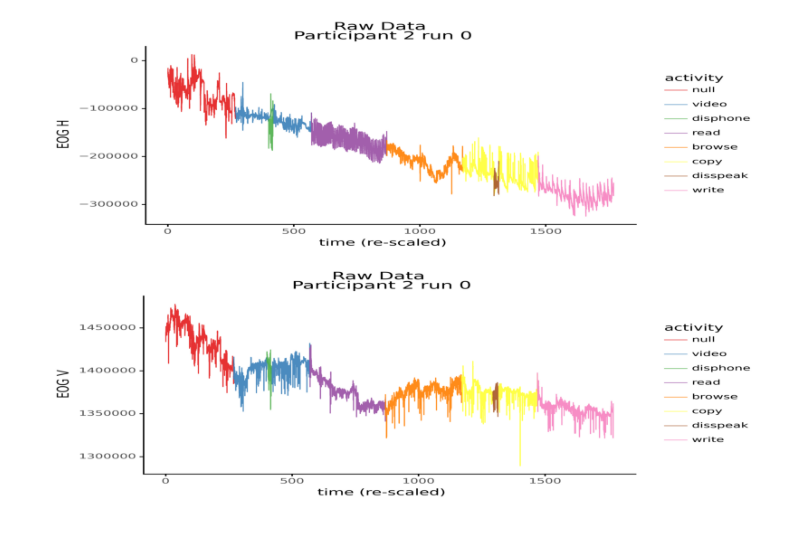

In [ ]:
import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread('CNS_EOG/imgs/eog_data/' + raw_data_plots[rand_exp])
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
#for i in range(len(data)):
#  data[i]['EOG_H_FFT'] = np.abs(np.fft.fft(data[i].EOG_H))**2
#  data[i]['EOG_V_FFT'] = np.abs(np.fft.fft(data[i].EOG_V))**2

In [ ]:
from scipy.signal import medfilt

medfilt_plots = sorted([f for f in os.listdir("CNS_EOG/imgs/median_filters")
                        if f.startswith('Participant_') and f.endswith('.png')])
# rand_exp = 1

for i in range(len(data)):
        data[i]['EOG_V_MedFilt'] = medfilt(data[i].EOG_V, kernel_size=5)
        data[i]['EOG_H_MedFilt'] = medfilt(data[i].EOG_H, kernel_size=5)

medfilt_data = []

for i in range(len(data)):

        medfilt_data_1 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_V)+1)),
                "Raw_EOG_V": list(data[i].EOG_V),
                "scipy_signal_medfilt_EOG_V": list(data[i].EOG_V_MedFilt)})
                .melt(var_name='median_filter_EOG_V', value_name='signal_EOG_V',
                id_vars=['time'],  value_vars=['Raw_EOG_V', 'scipy_signal_medfilt_EOG_V']))
        # display(medfilt_data_1)

        medfilt_data_2 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_V)+1)),
                "Raw_EOG_H": list(data[i].EOG_H),
                "scipy_signal_medfilt_EOG_H": list(data[i].EOG_H_MedFilt)})
                .melt(var_name='median_filter_EOG_H', value_name='signal_EOG_H',
                id_vars=['time'],  value_vars=['Raw_EOG_H', 'scipy_signal_medfilt_EOG_H']))
        # display(medfilt_data_2)

        medfilt_data.append(medfilt_data_1.merge(medfilt_data_2, on='time'))

if len(medfilt_plots) != 16:
        for i in range(len(data)):
                out_plot='CNS_EOG/imgs/median_filters/{}.png'.format(sample_preffixes[i])
                plot_title='Median Filter\n{}'.format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time'
                # y='signal'
                y1='signal_EOG_H'
                y2='signal_EOG_V'
                color_by_1='median_filter_EOG_H'
                color_by_2='median_filter_EOG_V'

                two_panel_plot(medfilt_data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.3, alpha=0.7, index=i, out_plot=out_plot)

del medfilt_data
gc.collect()

# Alternatives for baseline drift removal:

# .- own implementation
# .- [tested] eog_clean() from the library neurokit.
# .- [tested] pandas.rolling_median(data, window=5, center=True)

# Extra links
# https://medium.com/analytics-vidhya/signal-data-processing-for-scientific-data-analysis-with-python-part-1-90a90cb7f81


2375

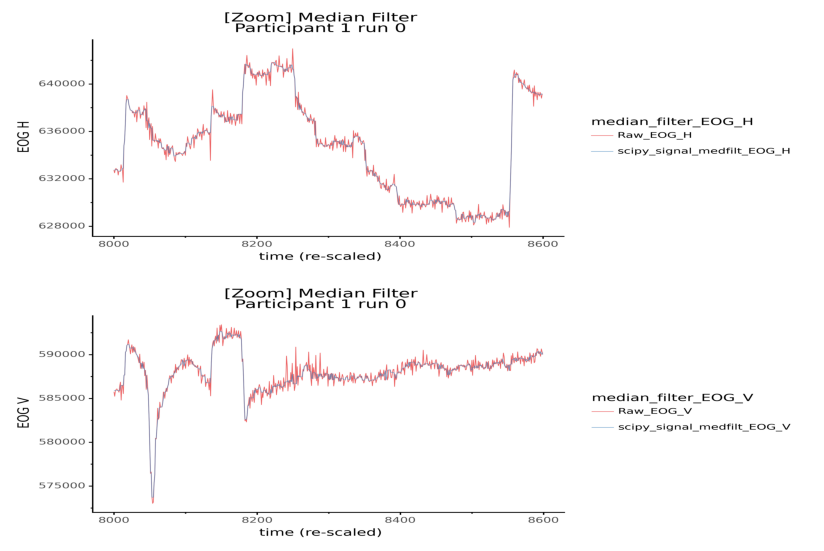

In [ ]:
temp = rand_exp
rand_exp = 0

medfilt_data_zoom_1 = (pd.DataFrame({
    "time": list(range(8000,8600)),
    "Raw_EOG_V": list(data[rand_exp].EOG_V[8000:8600]),
    "scipy_signal_medfilt_EOG_V": list(data[rand_exp].EOG_V_MedFilt[8000:8600])})
    .melt(var_name='median_filter_EOG_V', value_name='signal_EOG_V',
    id_vars=['time'],  value_vars=['Raw_EOG_V', 'scipy_signal_medfilt_EOG_V']))
# display(medfilt_data_zoom_1)

medfilt_data_zoom_2 = (pd.DataFrame({
    "time": list(range(8000,8600)),
    "Raw_EOG_H": list(data[rand_exp].EOG_H[8000:8600]),
    "scipy_signal_medfilt_EOG_H": list(data[rand_exp].EOG_H_MedFilt[8000:8600])})
    .melt(var_name='median_filter_EOG_H', value_name='signal_EOG_H',
    id_vars=['time'],  value_vars=['Raw_EOG_H', 'scipy_signal_medfilt_EOG_H']))
# display(medfilt_data_zoom_2)

medfilt_data_zoom = medfilt_data_zoom_1.merge(medfilt_data_zoom_2, on='time')
# display(medfilt_data_zoom)

out_plot=None
plot_title='[Zoom] Median Filter\n{}'.format(sample_titles[rand_exp])
x_lab="time (re-scaled)"
x='time'
y1='signal_EOG_H'
y2='signal_EOG_V'
color_by_1='median_filter_EOG_H'
color_by_2='median_filter_EOG_V'

two_panel_plot(medfilt_data_zoom, x, y1, y2, color_by_1, color_by_2,
        plot_title, x_lab, color_palette=brewer_set, size=0.3, alpha=0.7,
        index=None, out_plot=out_plot)

rand_exp = temp

In [ ]:
!yes | pip install BaselineRemoval --quiet

In [ ]:
from CNS_EOG.utils.bwr import calc_baseline
from BaselineRemoval import BaselineRemoval

basedrift_plots = sorted([f for f in os.listdir("CNS_EOG/imgs/baseline_drift_removal")
                        if f.startswith('Participant_') and f.endswith('.png')])

# rand_exp = 1

polynomial_degree = 2 # only needed for Modpoly and IModPoly algorithm

for i in range(len(data)):

        # Baseline Wander Removal with Wavelet Transform
        # https://github.com/spebern/py-bwr
        data[i]['EOG_H_BWR_BS'] = data[i].EOG_H_MedFilt - calc_baseline(data[i].EOG_H_MedFilt)
        data[i]['EOG_V_BWR_BS'] = data[i].EOG_V_MedFilt - calc_baseline(data[i].EOG_V_MedFilt)

        # Baseline Removal using Python implementation of Modified polyfit method, IModPoly method and Zhang fit method for baseline removal
        # https://pypi.org/project/BaselineRemoval/
        EOG_H_BRP_BL = BaselineRemoval(data[i].EOG_H_MedFilt)
        EOG_V_BRP_BL = BaselineRemoval(data[i].EOG_V_MedFilt)

        data[i]['EOG_H_BRP_Imod_d2'] = EOG_H_BRP_BL.IModPoly(polynomial_degree)
        data[i]['EOG_V_BRP_Imod_d2'] = EOG_V_BRP_BL.IModPoly(polynomial_degree)

basedrift_filt_data = []

for i in range(len(data)):

    basedrift_filt_data_1 = (pd.DataFrame({
            "time": list(range(1,len(data[i].EOG_H)+1)),
            "scipy_signal_medfilt_EOG_H": list(data[i].EOG_H_MedFilt),
            "BWR_EOG_H": list(data[i].EOG_H_BWR_BS),
            "BRP_Imod_d2_EOG_H": list(data[i].EOG_H_BRP_Imod_d2)})
            .melt(var_name='baseline_drift_filter_EOG_H', value_name='signal_EOG_H',
            id_vars=['time'],  value_vars=['scipy_signal_medfilt_EOG_H', 'BWR_EOG_H', 'BRP_Imod_d2_EOG_H']))
    # display(basedrift_filt_data_1)

    basedrift_filt_data_2 = (pd.DataFrame({
            "time": list(range(1,len(data[i].EOG_V)+1)),
            "scipy_signal_medfilt_EOG_V": list(data[i].EOG_V_MedFilt),
            "BWR_EOG_V": list(data[i].EOG_V_BWR_BS),
            "BRP_Imod_d2_EOG_V": list(data[i].EOG_V_BRP_Imod_d2)})
            .melt(var_name='baseline_drift_filter_EOG_V', value_name='signal_EOG_V',
            id_vars=['time'],  value_vars=['scipy_signal_medfilt_EOG_V', 'BWR_EOG_V', 'BRP_Imod_d2_EOG_V']))
    # display(basedrift_filt_data_2)


    basedrift_filt_data.append(basedrift_filt_data_1.merge(basedrift_filt_data_2, on='time'))

# display(basedrift_filt_data[0])

if len(basedrift_plots) != 16:
        for i in range(len(data)):
                out_plot='CNS_EOG/imgs/baseline_drift_removal/{}.png'.format(sample_preffixes[i])
                plot_title='Baseline Drift Removal\n{}'.format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time'
                y1='signal_EOG_H'
                y2='signal_EOG_V'
                color_by_1='baseline_drift_filter_EOG_H'
                color_by_2='baseline_drift_filter_EOG_V'

                two_panel_plot(basedrift_filt_data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.3, alpha=0.7, index=i, out_plot=out_plot)

# Alternatives for baseline drift removal:

# .- own implementation
# .- [tested] Baseline Wander Removal with Notch filter fro Python Heart Rate Analysis
# https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/_modules/heartpy/filtering.html
# .- [tested] Baseline Removal using "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
# https://stackoverflow.com/questions/29156532/python-baseline-correction-library


In [ ]:
def count_sequences(labels):
    result = []
    previous = labels[0]
    counter = 1
    for label in labels[1:]:
        if label != previous:
            result.append((previous, counter))
            counter = 0
        previous = label
        counter += 1
    result.append((previous, counter))
    return result


def plot_sequences(ground_truth, prediction):
    n = len(ground_truth)
    gt_seq = count_sequences(ground_truth)
    pred_seq = count_sequences(prediction)
    fig, ax = plt.subplots(figsize=(30, 2))
    ax.set_ylim(0, 2)
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
                '#ffff33', '#a65628', '#f781bf']
    curr = 0
    level = 1.25
    for label, size in gt_seq:
        rect = plt.Rectangle((curr / n, level), size / n, 0.5, color=colors[label])
        ax.add_patch(rect)
        curr += size
    curr = 0
    level = 0.25
    for label, size in pred_seq:
        rect = plt.Rectangle((curr / n, level), size / n, 0.5, color=colors[label])
        ax.add_patch(rect)
        curr += size

In [ ]:
all_data = pd.concat([data[0]])
for i in range(1, len(data)-2):
  all_data = pd.concat([all_data, data[i]], ignore_index=True)

train_X = all_data.filter(items=['EOG_H', 'EOG_V', 'EOG_V_MedFilt', 'EOG_H_MedFilt', 'EOG_V_BWR_BS', 'EOG_H_BWR_BS', 'EOG_V_BRP_Imod_d2', 'EOG_H_BRP_Imod_d2'])

train_y = all_data.filter(items=['class'])

test_data = pd.concat([data[14], data[15]])
test_X = test_data.filter(items=['EOG_H', 'EOG_V', 'EOG_V_MedFilt', 'EOG_H_MedFilt', 'EOG_V_BWR_BS', 'EOG_H_BWR_BS', 'EOG_V_BRP_Imod_d2', 'EOG_H_BRP_Imod_d2'])
test_y = test_data.filter(items=['class'])


### Random Forest Classifier


In [ ]:
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
lbl = preprocessing.LabelEncoder()
train_y = lbl.fit_transform(train_y.astype(int))
test_y = lbl.fit_transform(test_y.astype(int))

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 111)
rfc.fit(train_X, train_y)

In [ ]:
pred_rfc = rfc.predict(test_X)
recall_rfc, precision_rfc, f1_rfc, accuracy_rfc = recall_score(test_y[:], pred_rfc, average='macro'), precision_score(test_y[:], pred_rfc, average='macro'),\
f1_score(test_y[:], pred_rfc, average='macro'), accuracy_score(test_y[:], pred_rfc)
(f'accuracy: {accuracy_rfc}', f'recall: {recall_rfc}', f'precision: {precision_rfc}', f'f1: {f1_rfc}' )

('accuracy: 0.14577627125483608',
 'recall: 0.1037026500143414',
 'precision: 0.07160905746724562',
 'f1: 0.06463018502493147')

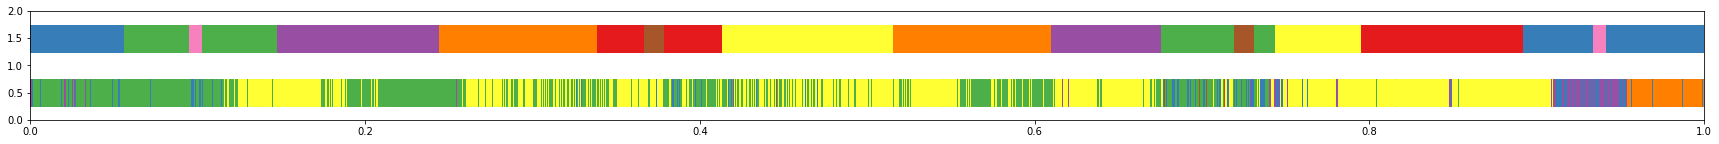

In [ ]:
plot_sequences(test_y[:], pred_rfc[:])

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=100, random_state=111)
abc.fit(train_X, train_y)


AdaBoostClassifier(n_estimators=100, random_state=111)

In [ ]:
pred_abc = abc.predict(test_X)
recall_abc, precision_abc, f1_abc, accuracy_abc = recall_score(test_y[:], pred_abc, average='macro'), precision_score(test_y[:], pred_abc, average='macro'),\
f1_score(test_y[:], pred_abc, average='macro'), accuracy_score(test_y[:], pred_abc)
(f'accuracy: {accuracy_abc}', f'recall: {recall_abc}', f'precision: {precision_abc}', f'f1: {f1_abc}', )

('accuracy: 0.14640426937840798',
 'recall: 0.12498463314790631',
 'precision: 0.1845511967054368',
 'f1: 0.07489551248846021')

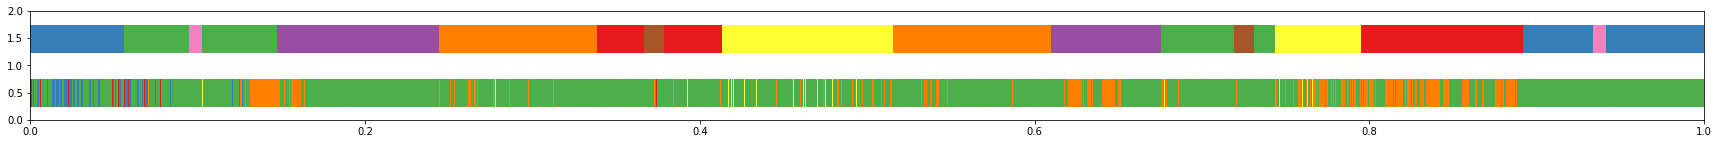

In [ ]:
plot_sequences(test_y[:], pred_abc[:])

### GradientBoostingClassifier


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=111)
gbm.fit(train_X, train_y)

In [ ]:
pred_gbm = gbm.predict(test_X)
recall_gbm, precision_gbm, f1_gbm, accuracy_gbm = recall_score(test_y[:], pred_gbm, average='macro'), precision_score(test_y[:], pred_gbm, average='macro'),\
f1_score(test_y[:], pred_gbm, average='macro'), accuracy_score(test_y[:], pred_gbm)
(f'accuracy: {accuracy_gbm}', f'recall: {recall_gbm}', f'precision: {precision_gbm}', f'f1: {f1_gbm}')

In [ ]:
plot_sequences(test_y[:], pred_gbm[:])